<a href="https://colab.research.google.com/github/rvjh/MYWays_FoodMNIST_rohan/blob/master/FoodMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
import os
import glob

import tensorflow as tf
import pandas as pd

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, GlobalAveragePooling2D, \
    Input, BatchNormalization, Activation

from tensorflow.keras.regularizers import l2

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, RMSprop
from sklearn.metrics import accuracy_score, confusion_matrix

import numpy as np
import matplotlib.pyplot as plt

In [85]:
# training
food = os.listdir('/content/drive/MyDrive/DeepL/Food_MNIST_subset/output/train')
print(food)

['beef_carpaccio', 'baklava', 'baby_back_ribs', 'apple_pie']


In [86]:
# apple training
t_apple = glob.glob('output/train/'+ food[0] + '/*')

# baby black ribs
t_baby = glob.glob('output/train/' + food[1] + '/*')

# baklava
t_baklava = glob.glob('output/train/' + food[2] + '/*')

# beef carpaccio
t_carpaccio = glob.glob('output/train/' + food[3] + '/*')

In [87]:
# testing

# apple training
te_apple = glob.glob('output/test/' + food[0] + '/*')

# baby black ribs
te_baby = glob.glob('output/test/' + food[1] + '/*')

# baklava
te_baklava = glob.glob('output/test/' + food[2] + '/*')

# beef carpaccio
te_carpaccio = glob.glob('output/test/' + food[3] + '/*')

In [88]:
# validation

# apple training
val_apple = glob.glob('output/val/' + food[0] + '/*')

# baby black ribs
val_baby = glob.glob('output/val/' + food[1] + '/*')

# baklava
val_baklava = glob.glob('output/val/' + food[2] + '/*')

# beef carpaccio
val_carpaccio = glob.glob('output/val/' + food[3] + '/*')

In [89]:
# training data generation
train_datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5,
    width_shift_range=0.04,
    height_shift_range=0.04,
    shear_range=0.2,
    zoom_range=0.2,
    channel_shift_range=0,
    fill_mode="nearest",
    cval=0,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1/255
)
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/DeepL/Food_MNIST_subset/output/train', target_size=(224, 224), batch_size=64)

test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/DeepL/Food_MNIST_subset/output/test', target_size=(224, 224), batch_size=64)

Found 1630 images belonging to 4 classes.
Found 208 images belonging to 4 classes.


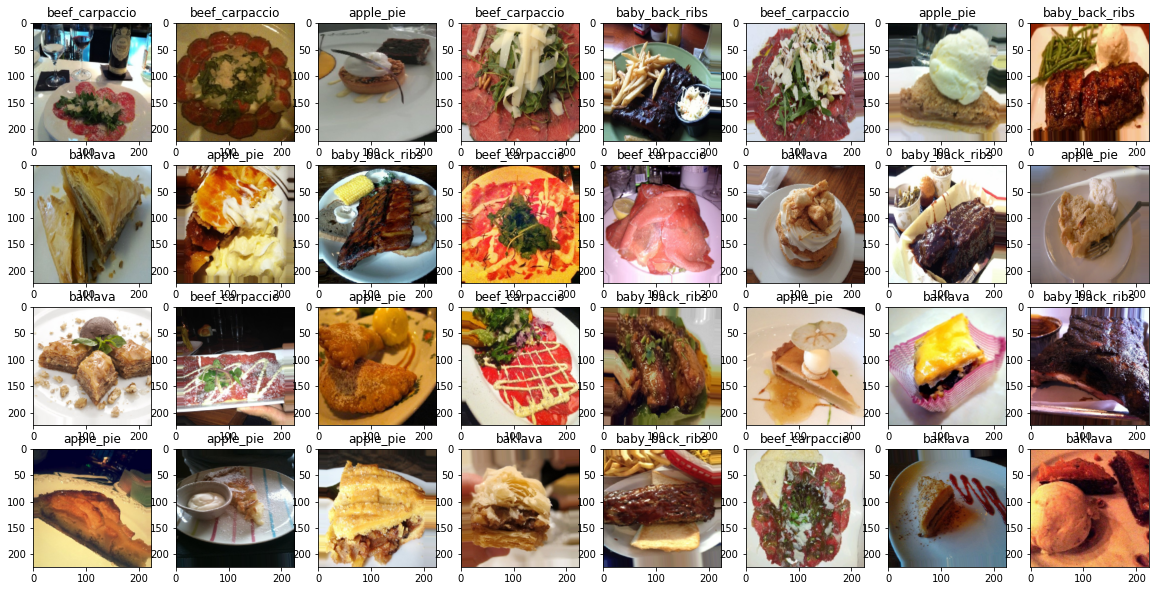

In [90]:
#EDA

p = 4
s = 8
n = 0
total_class = {"0": "apple_pie", "1": "baby_back_ribs", "2": "baklava", "3": "beef_carpaccio"}
for x in train_generator:
    fig, axes = plt.subplots(p, s, figsize=(20, 10))
    for i in range(p):
        for j in range(s):
            axes[i, j].imshow(x[0][n])
            label = np.argmax(x[1], axis=1)[n].astype('str')
            axes[i, j].set_title(total_class[label])
            n+=1
    plt.show()
    break

In [91]:
model = Sequential()

# Layer 1
model.add(Conv2D(filters=32, kernel_size=(5, 5), strides=2, padding='Same', activation='relu', input_shape=(224, 224, 3), kernel_initializer='he_normal'))
model.add(Conv2D(filters=32, kernel_size=(5, 5), strides=2, padding='Same', activation='relu', kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Layer 2
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu', kernel_initializer='he_normal'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu', kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))


# Layer 3
model.add(Conv2D(filters=128, kernel_size=(2, 2), padding='Same', activation='relu', kernel_initializer='he_normal'))
model.add(Conv2D(filters=128, kernel_size=(2, 2), padding='Same', activation='relu', kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Layer 4
model.add(Conv2D(filters=256, kernel_size=(2, 2), padding='Same', activation='relu', kernel_initializer='he_normal'))
model.add(Conv2D(filters=256, kernel_size=(2, 2), padding='Same', activation='relu', kernel_initializer='he_normal'))
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation="relu", kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(Dense(4, activation="softmax", kernel_initializer='he_normal',kernel_regularizer=l2()))

In [92]:
# callbacks
checkpointer = ModelCheckpoint(filepath='model.hdf5', verbose=1, save_best_only=True, save_weights_only=True)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, mode='auto')
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto')

In [93]:
model.compile(optimizer='Adam', loss="categorical_crossentropy", metrics=["accuracy"])

In [82]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 112, 112, 32)      2432      
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 56, 56, 32)        25632     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 64)       

In [96]:
history = model.fit(train_generator, steps_per_epoch=1600/64, validation_data=test_generator,validation_steps=200/64,
                    epochs=10, callbacks=[checkpointer, reduceLR, earlystopping])

## Go for higher epoch line 200 or 300

Epoch 1/10
25/25 [==============================] - 86s 3s/step - loss: 0.4833 - accuracy: 0.7752 - val_loss: 0.5645 - val_accuracy: 0.7452

Epoch 00001: val_loss improved from 0.56712 to 0.56451, saving model to model.hdf5
Epoch 2/10
25/25 [==============================] - 85s 3s/step - loss: 0.4745 - accuracy: 0.7848 - val_loss: 0.5961 - val_accuracy: 0.7404

Epoch 00002: val_loss did not improve from 0.56451
Epoch 3/10
25/25 [==============================] - 85s 3s/step - loss: 0.4713 - accuracy: 0.7905 - val_loss: 0.7063 - val_accuracy: 0.7019

Epoch 00003: val_loss did not improve from 0.56451
Epoch 4/10
25/25 [==============================] - 85s 3s/step - loss: 0.4813 - accuracy: 0.7867 - val_loss: 0.6684 - val_accuracy: 0.6923

Epoch 00004: val_loss did not improve from 0.56451
Epoch 5/10
25/25 [==============================] - 85s 3s/step - loss: 0.4808 - accuracy: 0.7854 - val_loss: 0.5906 - val_accuracy: 0.7404

Epoch 00005: val_loss did not improve from 0.56451
Epoch 6/

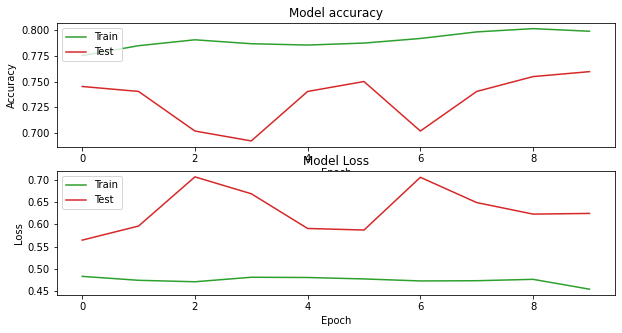

In [101]:
def plot_graph(history):
    fig, ax = plt.subplots(2, 1, figsize=(10, 5))
    ax[0].plot(history.history['accuracy'], c='C2')
    ax[0].plot(history.history['val_accuracy'], c='C3')
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Test'], loc='upper left')
    
    ax[1].plot(history.history['loss'], c='C2')
    ax[1].plot(history.history['val_loss'], c='C3')
    ax[1].set_title('Model Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='upper left')


plot_graph(history)